In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
df = pd.read_csv('Transformed Data Set - Sheet1.csv')
pd.set_option('display.max.columns', None)
df.head()


,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


In [3]:
oe_encoder = OrdinalEncoder()
df["Gender"] = oe_encoder.fit_transform(df[["Gender"]])
#oe_encoder.transform()
df

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,0.0
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,0.0
2,Warm,Rock,Wine,Coca Cola/Pepsi,0.0
3,Warm,Folk/Traditional,Whiskey,Fanta,0.0
4,Cool,Rock,Vodka,Coca Cola/Pepsi,0.0
...,...,...,...,...,...
61,Cool,Rock,Vodka,Coca Cola/Pepsi,1.0
62,Cool,Hip hop,Beer,Coca Cola/Pepsi,1.0
63,Neutral,Hip hop,Doesn't drink,Fanta,1.0
64,Cool,Rock,Wine,Coca Cola/Pepsi,1.0


In [4]:
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import validation_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
X = df[["Favorite Color", "Favorite Music Genre", "Favorite Beverage", "Favorite Soft Drink"]]
y = df["Gender"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
cat_selector = make_column_selector(dtype_include=["object"])
cat_processor = OneHotEncoder(handle_unknown='ignore')
preprocessor = make_column_transformer((cat_processor, cat_selector))

In [7]:
model = make_pipeline(preprocessor, DecisionTreeClassifier())
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14f833a90>)])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [21]:
model.score(X_test, y_test)
cross_val_score(model, X_train, y_train).mean()

0.5218181818181818

In [9]:
params = {'decisiontreeclassifier__criterion':['gini','entropy'],
          'decisiontreeclassifier__max_depth': np.arange(1,500,1)}
grid = GridSearchCV(model, param_grid=params, cv=5).fit(X_train, y_train)

In [10]:
print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14fcf5c10>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=474))])
0.5818181818181818


In [11]:
predict = model.predict(X_test)

print(classification_report(y_test,predict))
#precision 67% des femmes ont été correctement prédite 
#Recall 57% femmes ont été identifié par le modèle

              precision    recall  f1-score   support

         0.0       0.67      0.57      0.62         7
         1.0       0.62      0.71      0.67         7

    accuracy                           0.64        14
   macro avg       0.65      0.64      0.64        14
weighted avg       0.65      0.64      0.64        14



In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from scipy.stats import loguniform


In [41]:
grid_parameters = {'decisiontreeclassifier__max_depth':stats.randint(0, 500),
                   'decisiontreeclassifier__criterion':['gini','entropy']}


In [42]:
search = RandomizedSearchCV( model, grid_parameters, 
                            scoring='accuracy',
                            n_iter=10,
                            cv=5)
search.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x14f833a90>)])),
                                             ('decisiontreeclassifier',
                                              DecisionTreeClassifier())]),
                   param_distributions={'decisiontreeclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'decisiontreeclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14fc57a00>},
                   scoring='accuracy')

In [43]:
model_final = search.best_estimator_
model_final

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168fa00a0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=95))])

In [44]:
confusion_matrix(y_test, model.predict(X_test))

array([[4, 3],
       [2, 5]])

In [64]:
train_sizes, train_scores, test_scores = learning_curve(
                                                        estimator=model_final,
                                                        X=X,
                                                        y=y,
                                                        cv=5,
                                                        scoring="accuracy",
                                                        train_sizes = np.linspace(0.1,1,10)
)
print(train_sizes)
print(test_scores)

[ 5 10 15 20 26 31 36 41 46 52]
[[0.5        0.53846154 0.53846154 0.46153846 0.46153846]
 [0.5        0.53846154 0.53846154 0.46153846 0.46153846]
 [0.5        0.53846154 0.53846154 0.46153846 0.46153846]
 [0.5        0.53846154 0.53846154 0.46153846 0.46153846]
 [0.5        0.53846154 0.53846154 0.46153846 0.46153846]
 [0.42857143 0.38461538 0.53846154 0.46153846 0.38461538]
 [0.64285714 0.23076923 0.61538462 0.61538462 0.46153846]
 [0.42857143 0.61538462 0.69230769 0.46153846 0.69230769]
 [0.57142857 0.30769231 0.76923077 0.61538462 0.61538462]
 [0.35714286 0.69230769 0.46153846 0.38461538 0.53846154]]


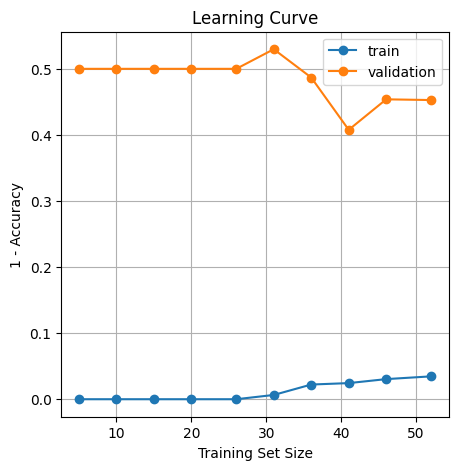

In [55]:
#train_mean = 1-train_scores.mean(axis=1)
#test_mean = 1-test_scores.mean(axis=1)

plt.subplots(figsize=(5,5))
plt.plot(train_sizes, train_mean, label="train", marker='o')
plt.plot(train_sizes, test_mean, label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("1 - Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [58]:
N, train_score, val_score = learning_curve(model,
                                           X,
                                           y,
                                           train_sizes=np.linspace(0.2, 1, 5),
                                           cv= 5)

for n, cv_train_scores, cv_test_scores in zip(
    N, train_scores, val_score
):
    print(f"{n} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

10 samples were used to train the model
The average train accuracy is 1.00
The average test accuracy is 0.50
20 samples were used to train the model
The average train accuracy is 1.00
The average test accuracy is 0.50
31 samples were used to train the model
The average train accuracy is 1.00
The average test accuracy is 0.55
41 samples were used to train the model
The average train accuracy is 1.00
The average test accuracy is 0.64
52 samples were used to train the model
The average train accuracy is 1.00
The average test accuracy is 0.61


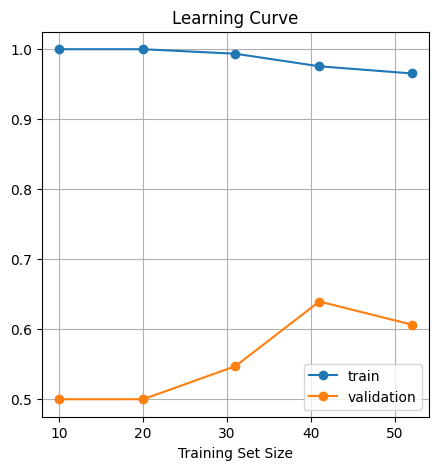

In [59]:
plt.subplots(figsize=(5,5))
plt.plot(N, train_score.mean(axis=1), label="train", marker='o')
plt.plot(N, val_score.mean(axis=1), label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
#plt.ylabel("Erreur : 1 - r2")
plt.legend(loc="best")
plt.grid(True)
plt.show()